Loading and preprocessing data...


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x72902106e340>
Traceback (most recent call last):
  File "/home/tuso/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/tuso/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tuso/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/tuso/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 's

Performing causal discovery using LiNGAM algorithm...


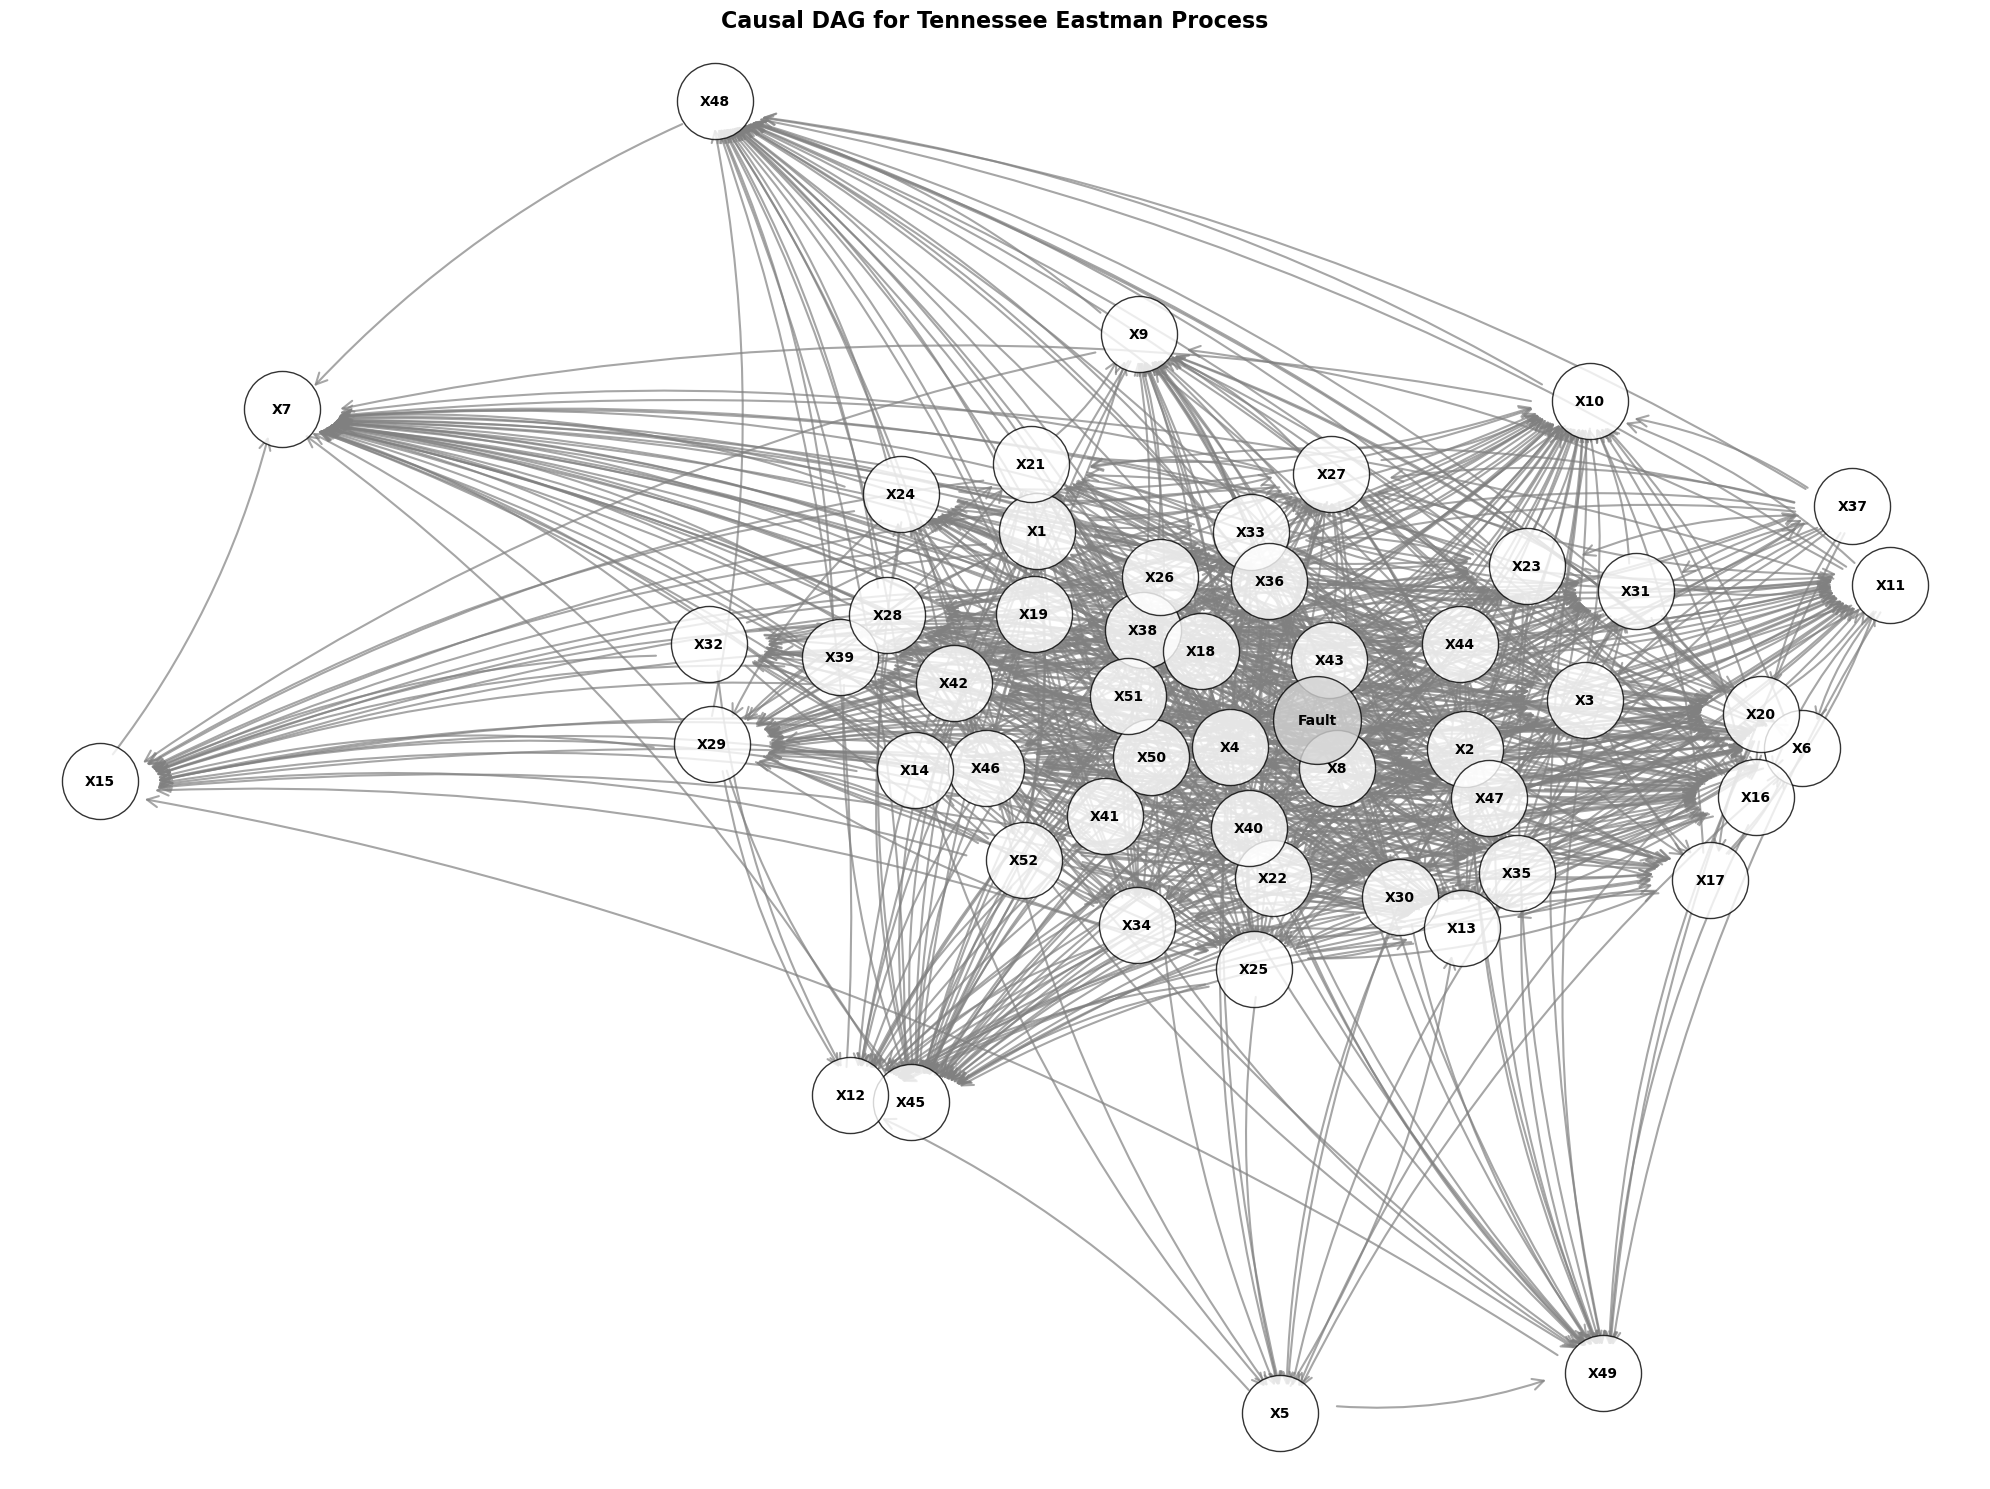

Edges in the causal graph:
X1 --> X2
X1 --> X3
X1 --> X6
X1 --> X7
X1 --> X10
X1 --> X11
X1 --> X15
X1 --> X16
X1 --> X20
X1 --> X23
X1 --> X25
X1 --> X27
X1 --> X29
X1 --> X30
X1 --> X31
X1 --> X33
X1 --> X34
X1 --> X36
X1 --> X38
X1 --> X39
X1 --> X42
X1 --> X43
X1 --> X44
X1 --> X45
X1 --> X48
X2 --> X3
X2 --> X5
X2 --> X6
X2 --> X7
X2 --> X9
X2 --> X10
X2 --> X11
X2 --> X13
X2 --> X16
X2 --> X17
X2 --> X20
X2 --> X21
X2 --> X22
X2 --> X23
X2 --> X25
X2 --> X27
X2 --> X28
X2 --> X29
X2 --> X30
X2 --> X33
X2 --> X34
X2 --> X35
X2 --> X45
X2 --> X48
X2 --> X49
X3 --> X6
X3 --> X7
X3 --> X9
X3 --> X10
X3 --> X11
X3 --> X12
X3 --> X13
X3 --> X16
X3 --> X17
X3 --> X20
X3 --> X21
X3 --> X22
X3 --> X24
X3 --> X25
X3 --> X27
X3 --> X29
X3 --> X31
X3 --> X33
X3 --> X34
X3 --> X45
X3 --> X48
X3 --> X49
X6 --> X5
X6 --> X7
X6 --> X9
X6 --> X10
X6 --> X12
X6 --> X13
X6 --> X16
X6 --> X45
X6 --> X48
X10 --> X7
X10 --> X45
X10 --> X48
X10 --> X49
X11 --> X6
X11 --> X7
X11 --> X9
X11 --> X10
X11 -

/tmp/ipykernel_369540/2804879264.py:331: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


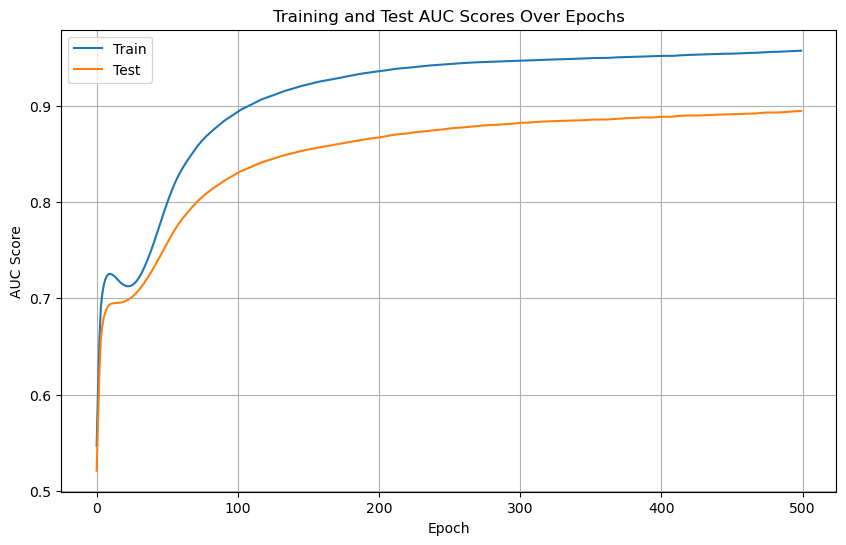

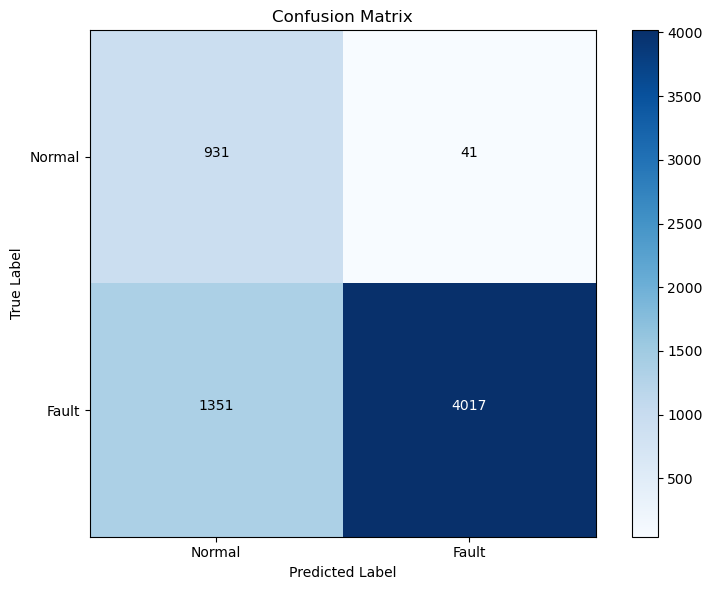

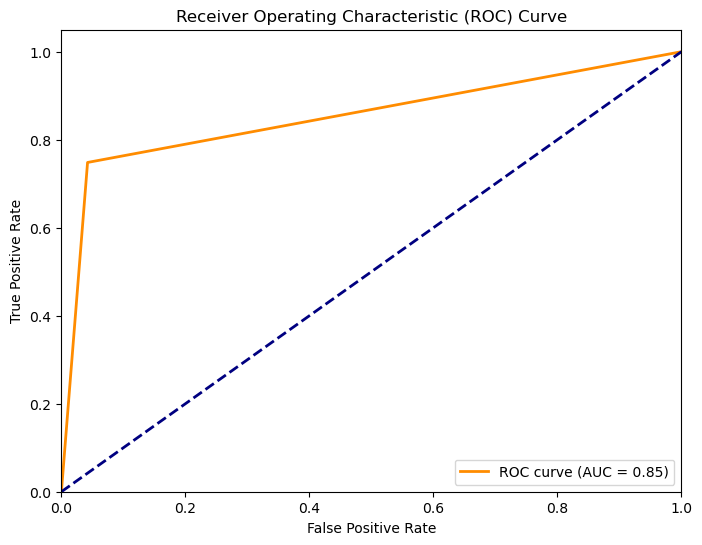

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (balanced_accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, roc_auc_score, 
                             matthews_corrcoef, log_loss, roc_curve, auc)
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GATv2Conv
from torch_geometric.loader import DataLoader
from causallearn.search.FCMBased import lingam
import networkx as nx
import itertools

torch.manual_seed(42)
np.random.seed(42)

# Define the path to the dataset
data_path = 'Documents/tennessee-eastmen-process-classification/TE_process/data/'

def load_data(file_path):
    data = pd.read_csv(file_path, sep=r'\s+', header=None)
    return data.values

def create_dataset():
    X = []
    y = []
    
    for i in range(22):
        train_file = os.path.join(data_path, f'd{i:02d}.dat')
        train_data = load_data(train_file)
        X.append(train_data)
        y.append(np.full(train_data.shape[0], 1 if i > 0 else 0))
        
        test_file = os.path.join(data_path, f'd{i:02d}_te.dat')
        test_data = load_data(test_file)
        X.append(test_data)
        if i == 0:
            y.append(np.zeros(test_data.shape[0]))
        else:
            y.append(np.concatenate([np.zeros(160), np.ones(test_data.shape[0] - 160)]))
    
    X = np.vstack(X)
    y = np.concatenate(y)
    
    return X, y

def create_causal_dag_with_output(X, y):
    # Combine X and y for LiNGAM algorithm
    data_with_output = np.column_stack((X, y))
    
    # Run LiNGAM algorithm
    model = lingam.ICALiNGAM()
    model.fit(data_with_output)
    
    # Create a NetworkX graph from the causal structure
    G = nx.DiGraph()
    n_features = X.shape[1]
    for i in range(n_features + 1):
        for j in range(n_features + 1):
            if model.adjacency_matrix_[i, j] != 0:
                G.add_edge(i, j)
    
    return G, model.adjacency_matrix_

def adjacency_matrix_to_edge_index(adj_matrix):
    edge_index = []
    edge_attr = []
    rows, cols = np.where(adj_matrix != 0)
    for row, col in zip(rows, cols):
        edge_index.append([row, col])
        edge_attr.append([adj_matrix[row, col], 0])  # Forward edge
        edge_index.append([col, row])
        edge_attr.append([0, adj_matrix[row, col]])  # Backward edge
    
    return (torch.tensor(edge_index, dtype=torch.long).t().contiguous(),
            torch.tensor(edge_attr, dtype=torch.float))

def plot_professional_causal_dag(G, num_features):
    plt.figure(figsize=(20, 15))
    
    actual_nodes = list(G.nodes())
    feature_nodes = [node for node in actual_nodes if node < num_features]
    output_node = max(actual_nodes)
    
    pos = nx.spring_layout(G, k=0.9, iterations=50)
    
    # Draw nodes
    feature_nodes_circles = nx.draw_networkx_nodes(G, pos, nodelist=feature_nodes, node_color='white', 
                                                   edgecolors='black', node_size=3000, alpha=0.8)
    output_node_circle = nx.draw_networkx_nodes(G, pos, nodelist=[output_node], node_color='lightgray', 
                                                edgecolors='black', node_size=4000, alpha=0.8)
    
    # Add node labels
    node_labels = {i: f"X{i+1}" for i in feature_nodes}
    node_labels[output_node] = 'Fault'
    nx.draw_networkx_labels(G, pos, node_labels, font_size=10, font_weight='bold')
    
    # Function to get edge connection points
    def get_connection_points(start_pos, end_pos, radius):
        angle = np.arctan2(end_pos[1] - start_pos[1], end_pos[0] - start_pos[0])
        start_point = (start_pos[0] + radius * np.cos(angle),
                       start_pos[1] + radius * np.sin(angle))
        end_point = (end_pos[0] - radius * np.cos(angle),
                     end_pos[1] - radius * np.sin(angle))
        return start_point, end_point
    
    # Draw edges with arrows
    for edge in G.edges():
        start_node, end_node = edge
        start_pos, end_pos = pos[start_node], pos[end_node]
        
        # Adjust radius based on node type (feature or output)
        start_radius = 0.04 if start_node != output_node else 0.05
        end_radius = 0.04 if end_node != output_node else 0.05
        
        start_point, end_point = get_connection_points(start_pos, end_pos, start_radius)
        
        arrow = ConnectionPatch(start_point, end_point, 'data', 'data', arrowstyle='->', 
                                mutation_scale=20, lw=1.5, alpha=0.7, color='gray',
                                connectionstyle='arc3,rad=0.1')
        plt.gca().add_patch(arrow)
    
    plt.title("Causal DAG for Tennessee Eastman Process", fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def create_directed_edge_index(G, num_nodes):
    edge_index = []
    edge_attr = []
    for edge in G.edges():
        edge_index.append([edge[0], edge[1]])
        edge_attr.append([1, 0])  # [1, 0] represents a forward edge
        edge_index.append([edge[1], edge[0]])
        edge_attr.append([0, 1])  # [0, 1] represents a backward edge
    return (torch.tensor(edge_index, dtype=torch.long).t().contiguous(),
            torch.tensor(edge_attr, dtype=torch.float))

class DirectedGNN(nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(DirectedGNN, self).__init__()
        self.conv1 = GATv2Conv(num_features, hidden_channels, edge_dim=2)
        self.conv2 = GATv2Conv(hidden_channels, hidden_channels // 2, edge_dim=2)
        self.fc = nn.Linear(hidden_channels // 2, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = self.relu(x)
        x = self.fc(x)
        return torch.sigmoid(x)

def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr).squeeze()
        loss = criterion(out, data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate_model(model, loader, device):
    model.eval()
    predictions = []
    targets = []
    out_probs = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr).squeeze()
            out_probs.extend(out.cpu().numpy())
            targets.extend(data.y.cpu().numpy())
    
    # Find optimal threshold
    fpr, tpr, thresholds = roc_curve(targets, out_probs)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    predictions = (np.array(out_probs) > optimal_threshold).astype(int)
    
    return (balanced_accuracy_score(targets, predictions), 
            precision_score(targets, predictions), 
            recall_score(targets, predictions), 
            f1_score(targets, predictions),
            matthews_corrcoef(targets, predictions), 
            roc_auc_score(targets, out_probs),
            log_loss(targets, out_probs), 
            predictions, targets, optimal_threshold)

def plot_training_history(train_scores, test_scores, title):
    plt.figure(figsize=(10, 6))
    plt.plot(train_scores, label='Train')
    plt.plot(test_scores, label='Test')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('AUC Score')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Normal', 'Fault'])
    plt.yticks(tick_marks, ['Normal', 'Fault'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Add text annotations
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def main():
    print("Loading and preprocessing data...")
    X, y = create_dataset()
    
    # First, split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Apply SMOTE only to the training data
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)  # Use the scaler fitted on training data
    
    print("Performing causal discovery using LiNGAM algorithm...")
    # Use only the training data for causal discovery
    G, adjacency_matrix = create_causal_dag_with_output(X_train_scaled, y_train_resampled)
    plot_professional_causal_dag(G, X_train_scaled.shape[1])
    
    # Print the edges of the graph
    print("Edges in the causal graph:")
    for edge in G.edges():
        print(f"X{edge[0]+1} --> X{edge[1]+1}" if edge[1] < X_train_scaled.shape[1] else f"X{edge[0]+1} --> Fault")
    
    edge_index, edge_attr = adjacency_matrix_to_edge_index(adjacency_matrix)
    
    # Create PyTorch geometric Data objects
    train_data = Data(x=torch.tensor(X_train_scaled, dtype=torch.float32),
                      edge_index=edge_index,
                      edge_attr=edge_attr,
                      y=torch.tensor(y_train_resampled, dtype=torch.float32))
    test_data = Data(x=torch.tensor(X_test_scaled, dtype=torch.float32),
                     edge_index=edge_index,
                     edge_attr=edge_attr,
                     y=torch.tensor(y_test, dtype=torch.float32))
    
    train_loader = DataLoader([train_data], batch_size=32, shuffle=True)
    test_loader = DataLoader([test_data], batch_size=32, shuffle=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DirectedGNN(num_features=X_train_scaled.shape[1], hidden_channels=128).to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    num_epochs = 500
    patience = 70
    best_auc = 0
    counter = 0
    train_auc_scores = []
    test_auc_scores = []
    
    for epoch in range(num_epochs):
        train_loss = train_model(model, train_loader, optimizer, criterion, device)
        _, _, _, _, _, train_auc, _, _, _, _ = evaluate_model(model, train_loader, device)
        test_bal_acc, test_prec, test_rec, test_f1, test_mcc, test_auc, test_logloss, test_preds, test_targets, threshold = evaluate_model(model, test_loader, device)
        
        print(f'Epoch {epoch+1}/{num_epochs}: Train AUC: {train_auc:.4f}, Test AUC: {test_auc:.4f}')
        
        train_auc_scores.append(train_auc)
        test_auc_scores.append(test_auc)
        
        # Early stopping based on AUC
        if test_auc > best_auc:
            best_auc = test_auc
            counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
            best_threshold = threshold
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
    
    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    
    # Final evaluation
    test_bal_acc, test_prec, test_rec, test_f1, test_mcc, test_auc, test_logloss, test_preds, test_targets, _ = evaluate_model(model, test_loader, device)
    print(f"Final Test Results: Balanced Accuracy: {test_bal_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_rec:.4f}, F1: {test_f1:.4f}, MCC: {test_mcc:.4f}, AUC: {test_auc:.4f}, Log Loss: {test_logloss:.4f}")
    
    plot_training_history(train_auc_scores, test_auc_scores, "Training and Test AUC Scores Over Epochs")
    plot_confusion_matrix(test_targets, test_preds)
    plot_roc_curve(test_targets, test_preds)

if __name__ == '__main__':
    main()